In [1]:
import yfinance as yf
import pandas as pd

# Fetch historical data for the Nifty 50 Index
ticker = "^NSEI"
data = yf.download(ticker, start="2022-01-01", end="2026-02-28")

print("Achievement Unlocked: Data successfully pulled for Nifty 50!")
print(data.head())

[*********************100%***********************]  1 of 1 completed

Achievement Unlocked: Data successfully pulled for Nifty 50!
Price              Close          High           Low          Open  Volume
Ticker             ^NSEI         ^NSEI         ^NSEI         ^NSEI   ^NSEI
Date                                                                      
2022-01-03  17625.699219  17646.650391  17383.300781  17387.150391  200500
2022-01-04  17805.250000  17827.599609  17593.550781  17681.400391  247400
2022-01-05  17925.250000  17944.699219  17748.849609  17820.099609  251500
2022-01-06  17745.900391  17797.949219  17655.550781  17768.500000  236500
2022-01-07  17812.699219  17905.000000  17704.550781  17797.599609  239300


# Nifty 50 Market Trend Predictor 
**Author:** Pulkit Sharma

## Project Overview
This project aims to predict the short-term directional movement of the Nifty 50 benchmark index using historical market data and Machine Learning. By engineering technical indicators like Moving Averages, this model classifies whether the next day's closing price will be higher or lower than the current day.

## 1. Data Extraction & Inspection
In this section, we utilize the `yfinance` API to extract historical daily price data for India's primary stock index.

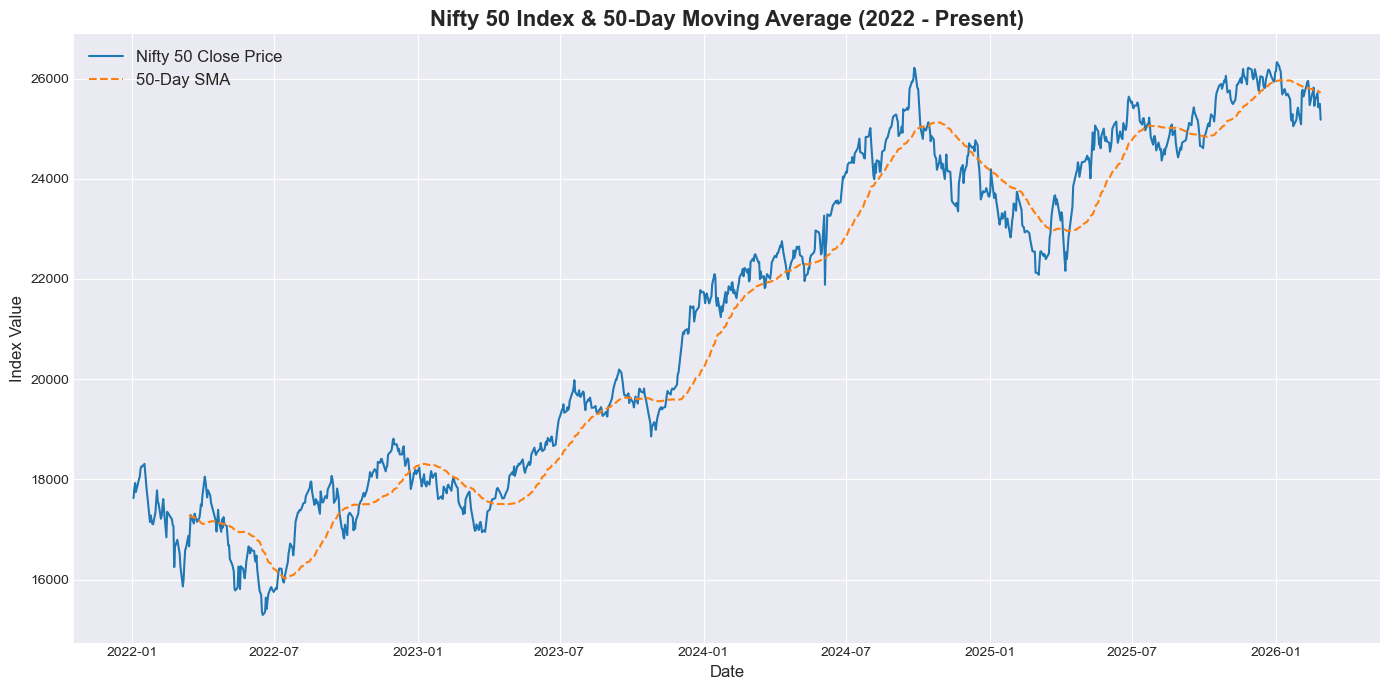

In [2]:
import matplotlib.pyplot as plt

# Calculate a 50-day Simple Moving Average (SMA)
data['SMA_50'] = data['Close'].rolling(window=50).mean()

# Set up the visualization style
plt.figure(figsize=(14, 7))
plt.style.use('seaborn-v0_8-darkgrid') 

# Plot the actual closing price and the SMA
plt.plot(data.index, data['Close'], label='Nifty 50 Close Price', color='#1f77b4', linewidth=1.5)
plt.plot(data.index, data['SMA_50'], label='50-Day SMA', color='#ff7f0e', linewidth=1.5, linestyle='--')

# Add titles and labels for presentation quality
plt.title('Nifty 50 Index & 50-Day Moving Average (2022 - Present)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Index Value', fontsize=12)
plt.legend(loc='upper left', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

## 2. Feature Engineering: Technical Indicators
To give our predictive model more context than raw prices, we engineer technical indicators. 

**Relative Strength Index (RSI):** A momentum indicator evaluating overbought or oversold conditions. The formula is:
$$RSI = 100 - \frac{100}{1 + RS}$$
*(Where RS is the average of upward price changes over a chosen period divided by the average of downward price changes).*

In [3]:
# Calculate 14-day RSI using Exponential Moving Average (Wilder's Smoothing)
delta = data['Close'].diff()
gain = delta.clip(lower=0)
loss = -1 * delta.clip(upper=0)

ema_up = gain.ewm(com=13, adjust=False).mean()
ema_down = loss.ewm(com=13, adjust=False).mean()

rs = ema_up / ema_down
data['RSI'] = 100 - (100 / (1 + rs))

# Drop NaN values created by our moving averages
data.dropna(inplace=True)

print("Achievement Unlocked: RSI feature engineered successfully!")

Achievement Unlocked: RSI feature engineered successfully!


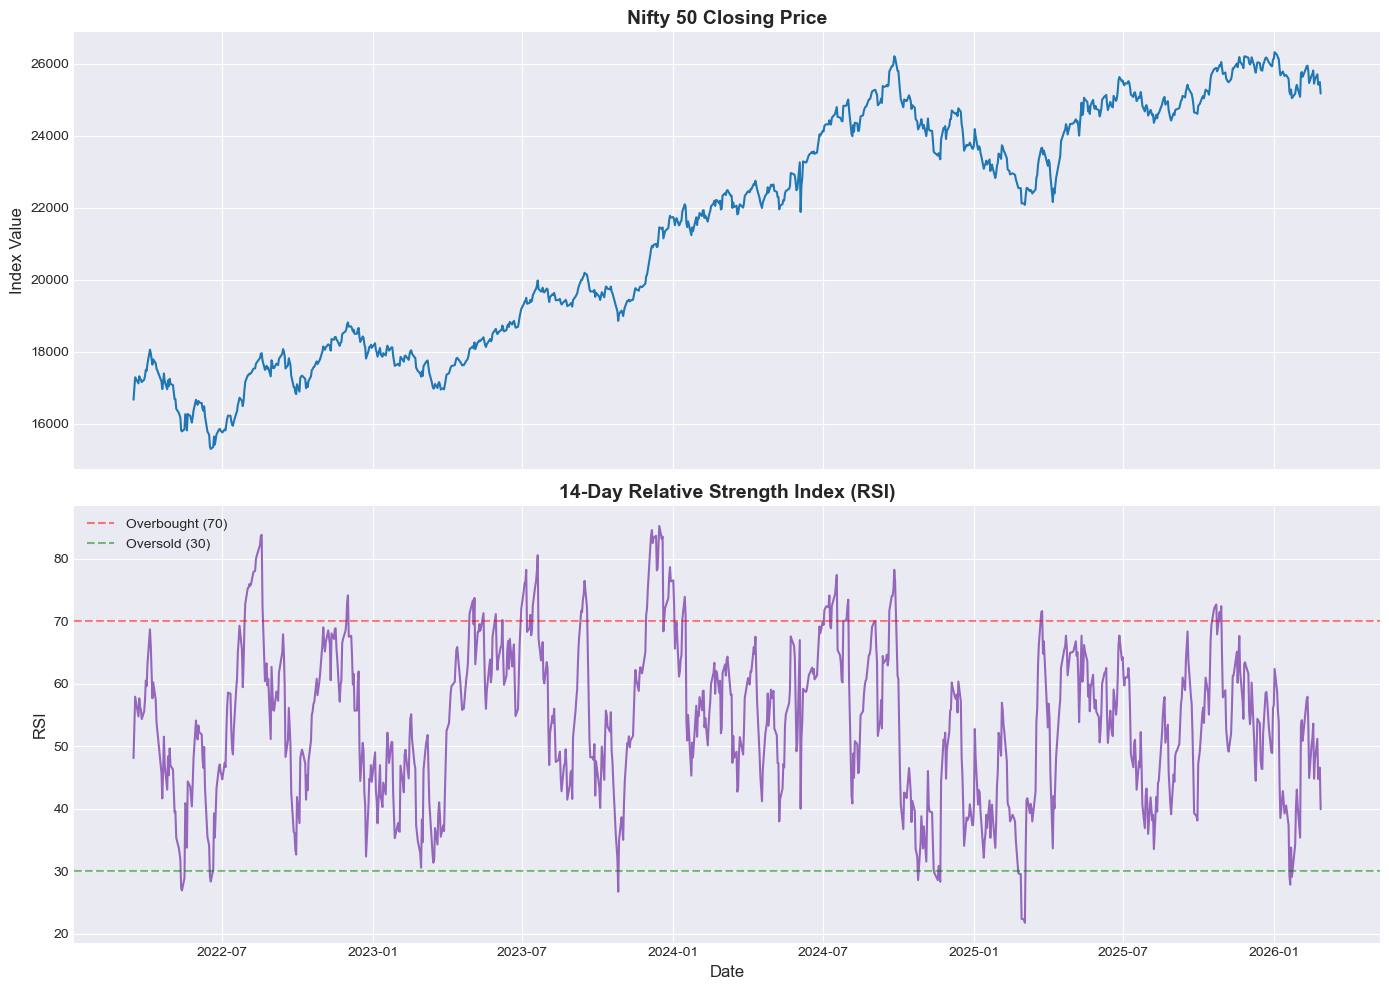

In [4]:
# Create a figure with 2 subplots (Price on top, RSI on bottom)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
plt.style.use('seaborn-v0_8-darkgrid')

# Top Subplot: Nifty 50 Close Price
ax1.plot(data.index, data['Close'], color='#1f77b4', linewidth=1.5)
ax1.set_title('Nifty 50 Closing Price', fontsize=14, fontweight='bold')
ax1.set_ylabel('Index Value', fontsize=12)

# Bottom Subplot: 14-Day RSI
ax2.plot(data.index, data['RSI'], color='#9467bd', linewidth=1.5)
ax2.axhline(70, color='red', linestyle='--', alpha=0.5, label='Overbought (70)')
ax2.axhline(30, color='green', linestyle='--', alpha=0.5, label='Oversold (30)')
ax2.set_title('14-Day Relative Strength Index (RSI)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('RSI', fontsize=12)
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [5]:
# Create the Target Variable
# Shift the closing price backwards by 1 to represent "tomorrow's price"
# If tomorrow's price is greater than today's, assign 1 (Up). Otherwise, 0 (Down).

data['Target'] = (data['Close'].shift(-1) > data['Close']).astype(int)

# Drop the last row since we don't know "tomorrow's" price for the very last day
data.dropna(inplace=True)

print("Achievement Unlocked: Target variable created!")
print(data[['Close', 'RSI', 'Target']].tail())

Achievement Unlocked: Target variable created!
Price              Close        RSI Target
Ticker             ^NSEI                  
Date                                      
2026-02-23  25713.000000  51.199600      0
2026-02-24  25424.650391  44.786487      1
2026-02-25  25482.500000  46.241331      1
2026-02-26  25496.550781  46.609309      0
2026-02-27  25178.650391  39.946900      0


## 3. Machine Learning Setup: Time-Series Split
Unlike standard datasets, financial market data is sequential. We cannot use random shuffling to split our data, as that would introduce look-ahead bias (using future information to predict the past). 

We will use the first 80% of our timeline to train the model, and the final 20% to test its predictive power on "unseen" future market conditions.

**Model Selection:** We are utilizing a `RandomForestClassifier`. It is an ensemble method that handles non-linear relationships well and is highly interpretable, making it ideal for financial baseline models.

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
import warnings
warnings.filterwarnings('ignore') # Keeps the notebook clean for presentation

# 1. Define Features (X) and Target (y)
features = ['Close', 'SMA_50', 'RSI']
X = data[features]
y = data['Target']

# 2. Chronological Train-Test Split (80/20)
split_index = int(len(data) * 0.8)

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# 3. Initialize and Train the Model
# n_estimators: number of trees | min_samples_split: prevents overfitting
model = RandomForestClassifier(n_estimators=100, min_samples_split=50, random_state=42)
model.fit(X_train, y_train)

# 4. Generate Predictions on the Test Set
predictions = model.predict(X_test)

# 5. Evaluate the Model
precision = precision_score(y_test, predictions)

print("Achievement Unlocked: Model successfully trained!")
print(f"Baseline Precision Score: {precision * 100:.2f}%")

Achievement Unlocked: Model successfully trained!
Baseline Precision Score: 53.19%


## 4. Model Evaluation & Interpretability
To understand the driving factors behind our model's predictions, we extract the feature importances from the Random Forest. This tells us which technical indicators carry the most predictive weight.

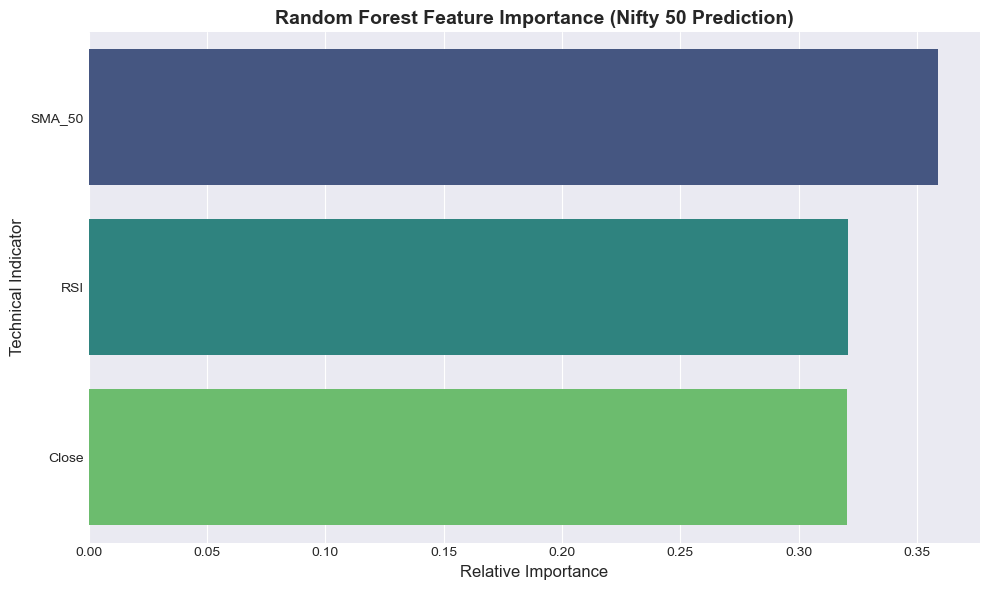

Achievement Unlocked: Feature Importance visualized!


In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Extract feature importances from the trained model
importances = model.feature_importances_

# FIX: Extract just the first part of the column name if it is a MultiIndex tuple
# This converts ('Close', '^NSEI') into simply 'Close'
feature_names = [col[0] if isinstance(col, tuple) else col for col in X.columns]

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the values for better visualization
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Random Forest Feature Importance (Nifty 50 Prediction)', fontsize=14, fontweight='bold')
plt.xlabel('Relative Importance', fontsize=12)
plt.ylabel('Technical Indicator', fontsize=12)
plt.tight_layout()
plt.show()

print("Achievement Unlocked: Feature Importance visualized!")

### 5. Confusion Matrix
This matrix visualizes the exact breakdown of our model's performance, contrasting its True Positives and True Negatives against its prediction errors.

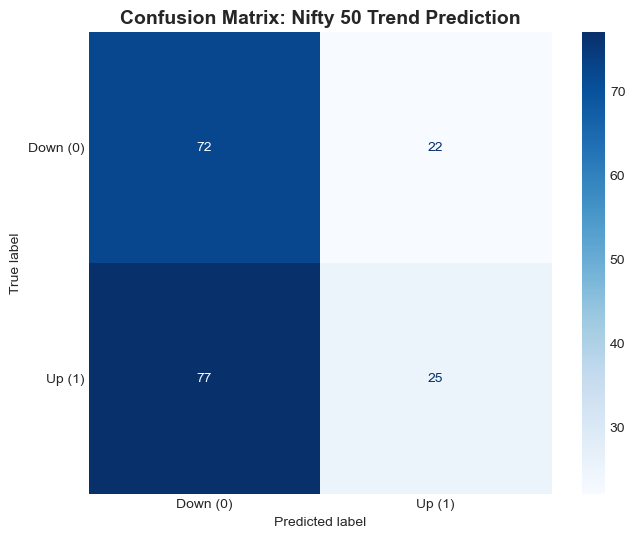

Achievement Unlocked: Confusion Matrix successfully mapped!


In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Visualize it using ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Down (0)', 'Up (1)'])
disp.plot(cmap='Blues', ax=ax, values_format='d')

plt.title('Confusion Matrix: Nifty 50 Trend Prediction', fontsize=14, fontweight='bold')
plt.grid(False) 
plt.show()

print("Achievement Unlocked: Confusion Matrix successfully mapped!")